# SMS SPAM DETECTOR USING MACHINE LEARNING

In [1]:
!pip install nltk

In [6]:
!pip install wordcloud


     ------------------------------------ 153.3/153.3 kB 179.5 kB/s eta 0:00:00


# Load the libraries

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.ensemble import StackingClassifier
import pickle

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santhoshini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load the dataset

In [25]:
df = pd.read_csv("spam.csv", encoding="latin-1")

In [26]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4109,ham,"Yo, you gonna still be in stock tomorrow/today...",NaN,NaN,NaN
1636,ham,"No shit, but I wasn't that surprised, so I wen...",NaN,NaN,NaN
3221,ham,"Hi, my love! How goes that day? Fuck, this mor...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
104,ham,Umma my life and vava umma love you lot dear,NaN,NaN,NaN


In [27]:
df.shape

(5572, 5)

# Data cleaning

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [29]:
# drop last 3 column
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [30]:
df.sample(5)

,v1,v2
27,ham,Did you catch the bus ? Are you frying an egg ...
1244,ham,Now? I'm going out 4 dinner soon..
4322,ham,Aight well keep me informed
4047,ham,Lol or I could just starve and lose a pound by...
589,ham,"I'm in a meeting, call me later at"


In [31]:
# renaming the columns
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
704,ham,True dear..i sat to pray evening and felt so.s...
3521,ham,Im sorry bout last nite it wasnåÕt ur fault it...
1749,ham,DO NOT B LATE LOVE MUM
1942,ham,K...k:)why cant you come here and search job:)
4861,spam,**FREE MESSAGE**Thanks for using the Auction S...


In [32]:
#encoding
encoder = LabelEncoder()

In [33]:
df['target'] = encoder.fit_transform(df['target'])

In [34]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
# check for missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [36]:
# check for duplicate values
df.duplicated().sum()

403

In [37]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [38]:
df.duplicated().sum()

0

In [39]:
df.shape

(5169, 2)

# EDA

In [40]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

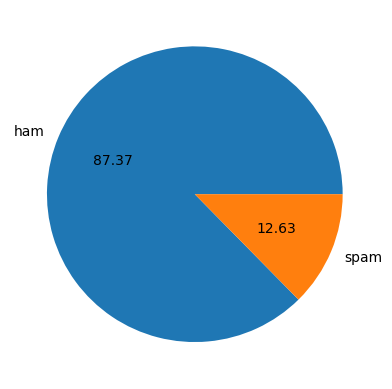

In [43]:
#Pie chart to visualize the count of ham & spam messages 
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [45]:
#data is imbalanced
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [46]:
# number of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [47]:
# number of sentences
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [48]:
#Descriptive statistics
df[['num_characters','num_words','num_sentences']].describe()


,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [49]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [50]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


<AxesSubplot:xlabel='num_characters', ylabel='Count'>

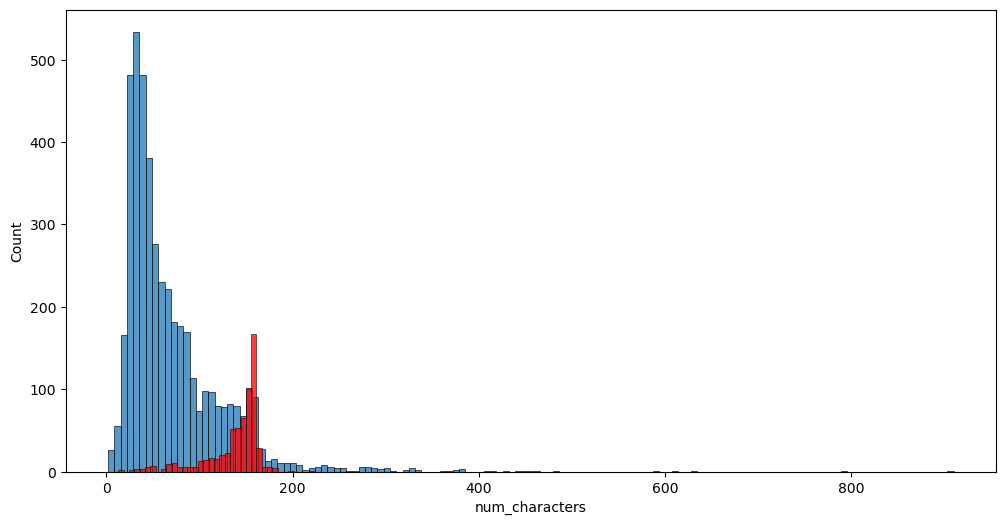

In [51]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

<AxesSubplot:xlabel='num_words', ylabel='Count'>

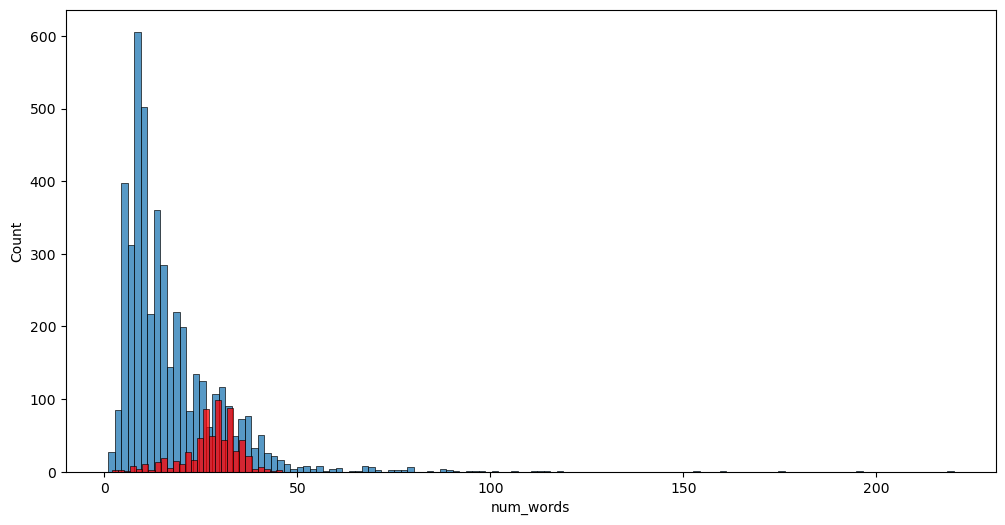

In [52]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

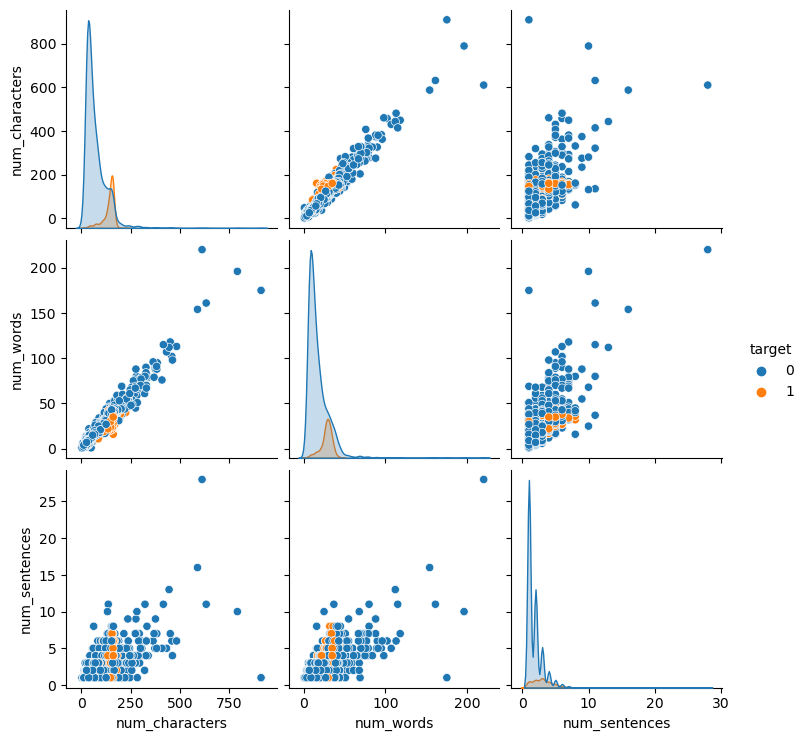

In [53]:
sns.pairplot(df,hue='target')

<AxesSubplot:>

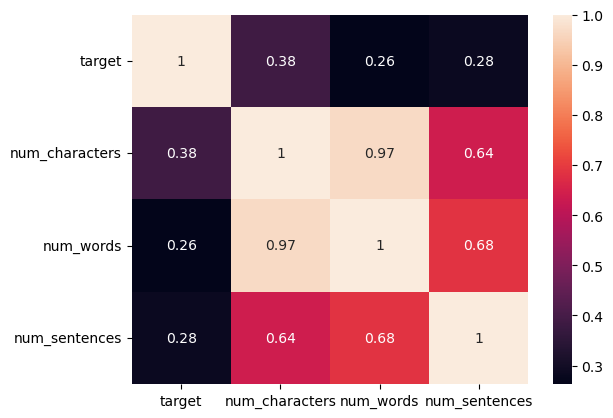

In [54]:
sns.heatmap(df.corr(),annot=True)

# Data preprocessing

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santhoshini\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [63]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    ps = PorterStemmer()
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [64]:
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [65]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [67]:
ps = PorterStemmer()
ps.stem('loving')

'love'

In [68]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [69]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [70]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

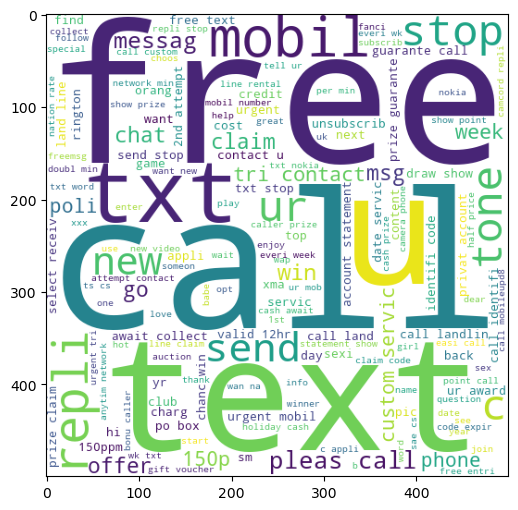

In [71]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

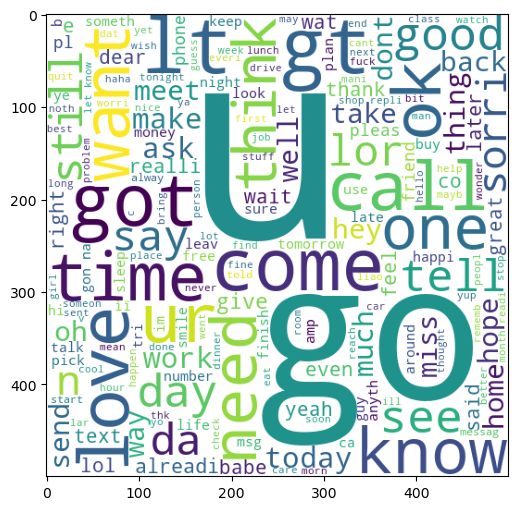

In [72]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [73]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [74]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [75]:
len(spam_corpus)

9939

C:\Users\santhoshini\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


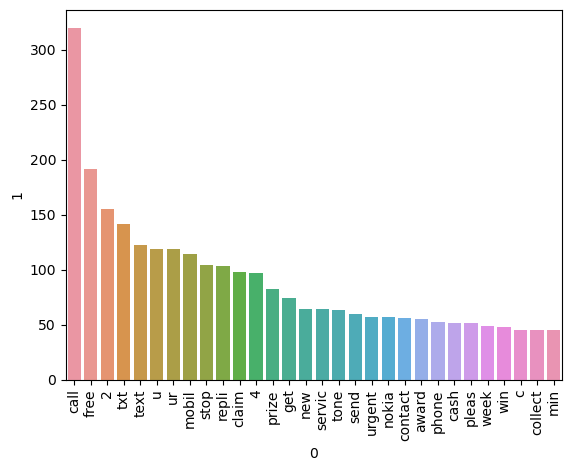

In [76]:
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [77]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [78]:
len(ham_corpus)

35394

C:\Users\santhoshini\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


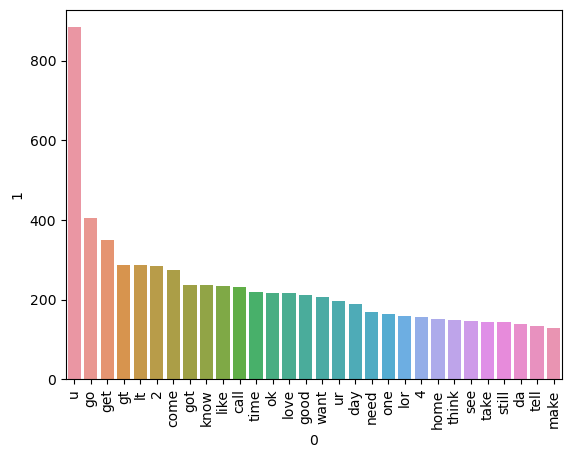

In [79]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [80]:
# Text Vectorization using Bag of Words
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


# Model building

In [81]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [82]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [83]:
X.shape

(5169, 3000)

In [84]:
y = df['target'].values

In [85]:
#split into train and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [86]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [87]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print("accuracy:", accuracy_score(y_test,y_pred1))
print("confusion matrix:", confusion_matrix(y_test,y_pred1))
print("precision score:", precision_score(y_test,y_pred1))

accuracy: 0.8694390715667312
confusion matrix: [[788 108]
 [ 27 111]]
precision score: 0.5068493150684932


In [88]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print("accuracy:",accuracy_score(y_test,y_pred2))
print("confusion matrix:",confusion_matrix(y_test,y_pred2))
print("precision score:",precision_score(y_test,y_pred2))

accuracy: 0.9709864603481625
confusion matrix: [[896   0]
 [ 30 108]]
precision score: 1.0


In [89]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print("accuracy:",accuracy_score(y_test,y_pred3))
print("confusion matrix:",confusion_matrix(y_test,y_pred3))
print("precision score:",precision_score(y_test,y_pred3))

accuracy: 0.9835589941972921
confusion matrix: [[895   1]
 [ 16 122]]
precision score: 0.991869918699187


In [92]:
!pip install xgboost

  Using cached xgboost-2.0.2-py3-none-win_amd64.whl (99.8 MB)


In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [94]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [95]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [96]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [97]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9758220502901354, 0.9747899159663865)

In [98]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9758220502901354
Precision -  0.9747899159663865


C:\Users\santhoshini\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB
Accuracy -  0.9709864603481625
Precision -  1.0
For  DT
Accuracy -  0.9303675048355899
Precision -  0.8173076923076923
For  LR
Accuracy -  0.9584139264990329
Precision -  0.9702970297029703
For  RF
Accuracy -  0.9748549323017408
Precision -  0.9827586206896551
For  AdaBoost
Accuracy -  0.960348162475822
Precision -  0.9292035398230089
For  BgC
Accuracy -  0.9574468085106383
Precision -  0.8671875
For  ETC
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406
For  GBDT
Accuracy -  0.9477756286266924
Precision -  0.92
For  xgb
Accuracy -  0.9661508704061895
Precision -  0.9256198347107438


In [102]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [103]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.974855,0.982759
0,SVC,0.975822,0.974790
8,ETC,0.974855,0.974576
4,LR,0.958414,0.970297
6,AdaBoost,0.960348,0.929204
10,xgb,0.966151,0.925620
9,GBDT,0.947776,0.920000
7,BgC,0.957447,0.867188


In [104]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [105]:
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.905222
1,NB,Accuracy,0.970986
2,RF,Accuracy,0.974855
3,SVC,Accuracy,0.975822
4,ETC,Accuracy,0.974855
5,LR,Accuracy,0.958414
6,AdaBoost,Accuracy,0.960348
7,xgb,Accuracy,0.966151
8,GBDT,Accuracy,0.947776
9,BgC,Accuracy,0.957447


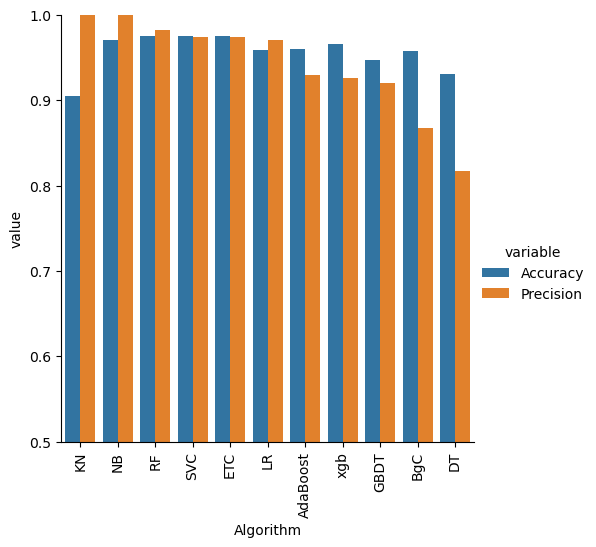

In [106]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [107]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [108]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [109]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [110]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9917355371900827


In [111]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [112]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [113]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9777562862669246
Precision 0.9323308270676691
